In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from parse_levels import find_levels_in_configs, find_levels_in_configs_glob
from parse_levels import process_metrics, human_train_time_dict, convert_to_dict, compute_gap_in_percentage, compute_gap_in_percentage_list, convert_to_dict_multiple_runs
from parse_levels import filter_folder_info, compute_gap_in_percentage_list_keep_name
import pandas as pd
import matplotlib.ticker as ticker
from plot_utils import plot_gap_comparison, gather_metrics
import re
import copy
import json

In [3]:
# for each item in the dict, if any two have the same 'record', remove the one with lower number of steps in metric
# def deduplicate_metrics(search_results):
#     records_length_so_far = {}
#     new_search_results = {}
#     for key, value in search_results.items():
#         if value['record'] not in records_length_so_far:
#             records_length_so_far[value['record']] = (len(value['metrics']['step']), key)
#             new_search_results[key] = value
#         else:
#             if len(value['metrics']['step']) > records_length_so_far[value['record']][0]:
#                 new_search_results.pop(records_length_so_far[value['record']][1])

#                 records_length_so_far[value['record']] = (len(value['metrics']['step']), key)
#                 new_search_results[key] = value
#     return new_search_results


In [4]:
# ori_results = find_levels_in_configs_glob(
#     [
#         '/checkpoint/maui/zhaobc/scientist/workspace/record_*',
#         '/checkpoint/maui/zhaobc/scientist/workspace/0511_relaunch/record_*',
#         '/checkpoint/maui/zhaobc/scientist/workspace/0507_relaunch/record_*',
#         '/checkpoint/maui/zhaobc/scientist/workspace/r1_relaunch/record_*'
#     ]
# )

In [5]:
# with open('june1.cache', 'w') as f:
#     json.dump(ori_results, f)

In [6]:
# with open('may8.cache', 'r') as f:
#     ori_results = json.load(f)
with open('june1.cache', 'r') as f:
    ori_results = json.load(f)

In [7]:
# z_folder_info = filter_folder_info(ori_results, [('levels', 'z')])
unique_models = set()
for key, value in ori_results.items():
    unique_models.add(value['model'])
unique_models

{'deepseek-r1', 'gemini-2.5-pro', 'o3-mini'}

In [8]:
# 1 is psuedo-code
# 2 is text description
# 5 is paper like
# 9 is adhoc knowledge, we can ignore it for now
# 'z' is zero knowledge

In [9]:
folder_info = ori_results
# o3_results

In [10]:
len(folder_info)

5409

In [11]:
# flat search -- n_initial_hypotheses = 50
flat_params = [
    ('runner', 'bon'),
    # ('n_initial_hypotheses', 50),
    ('n_iterations', 1),
]
# tree search -- n_initial_hypotheses = 1, n_hypotheses = 3
tree_params = [
    ('runner', 'bon'),
    ('n_initial_hypotheses', 1),
    ('n_hypotheses', 3),
]
# forest search -- n_initial_hypotheses = 3, n_hypotheses = 3
forest_params = [
    ('runner', 'bon'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 3),
]
# AIDE -- n_initial_hypotheses = 3, n_hypotheses = 1, debug_prob = 0.5
aide_params = [
    ('runner', 'aide'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 1),
    ('debug_prob', 0.5),
]
# MultiAIDE -- n_initial_hypotheses = 3, n_hypotheses = 3, debug_prob = 0.5
multi_aide_params = [
    ('runner', 'aide'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 3),
    ('debug_prob', 0.5),
]

search_algo_params = {
    'flat': flat_params,
    'tree': tree_params,
    'forest': forest_params,
    'ori_aide': aide_params,
    'multi_aide': multi_aide_params,
}

plot_info = {}

for search_algo, params in search_algo_params.items():
    plot_info[search_algo] = {}
    for level in ['z', 1, 2, 5, 12, 125]:
        plot_info[search_algo][level] = {}
        for model in ['deepseek-r1', 'gemini-2.5-pro', 'o3-mini']:
        # for model in ['o3-mini']:
            search_params = params + [('levels', level), ('model', model)]
            filtered_folder_info = filter_folder_info(folder_info, search_params)
            print(f'{search_algo} {level} {model} {len(filtered_folder_info)}')
            plot_info[search_algo][level][model] = filtered_folder_info


flat z deepseek-r1 29
flat z gemini-2.5-pro 57
flat z o3-mini 60
flat 1 deepseek-r1 31
flat 1 gemini-2.5-pro 57
flat 1 o3-mini 99
flat 2 deepseek-r1 29
flat 2 gemini-2.5-pro 57
flat 2 o3-mini 60
flat 5 deepseek-r1 60
flat 5 gemini-2.5-pro 57
flat 5 o3-mini 60
flat 12 deepseek-r1 71
flat 12 gemini-2.5-pro 57
flat 12 o3-mini 64
flat 125 deepseek-r1 75
flat 125 gemini-2.5-pro 57
flat 125 o3-mini 55
tree z deepseek-r1 29
tree z gemini-2.5-pro 55
tree z o3-mini 60
tree 1 deepseek-r1 27
tree 1 gemini-2.5-pro 57
tree 1 o3-mini 106
tree 2 deepseek-r1 29
tree 2 gemini-2.5-pro 57
tree 2 o3-mini 60
tree 5 deepseek-r1 60
tree 5 gemini-2.5-pro 57
tree 5 o3-mini 60
tree 12 deepseek-r1 58
tree 12 gemini-2.5-pro 47
tree 12 o3-mini 51
tree 125 deepseek-r1 75
tree 125 gemini-2.5-pro 49
tree 125 o3-mini 74
forest z deepseek-r1 29
forest z gemini-2.5-pro 57
forest z o3-mini 60
forest 1 deepseek-r1 27
forest 1 gemini-2.5-pro 57
forest 1 o3-mini 106
forest 2 deepseek-r1 29
forest 2 gemini-2.5-pro 57
forest 

In [12]:
from tqdm import tqdm

figure_data = {}
for search_algo in search_algo_params.keys():
    for level in ['z', 1, 2, 5, 12, 125]:
        # for model in ['o3-mini']:
        # for model in ['deepseek-r1', 'o3-mini']:
        for model in ['deepseek-r1', 'gemini-2.5-pro', 'o3-mini']:
            plot_info[search_algo][level][model] = process_metrics(plot_info[search_algo][level][model])
            # plot_info[search_algo][level][model] = deduplicate_metrics(plot_info[search_algo][level][model])
            figure_data[f'{search_algo}_{level}_{model}'] = convert_to_dict_multiple_runs(plot_info[search_algo][level][model], keep_name=True)


In [13]:
human_train_time_dict = {
    1: 2968348,
    2: 2209926,
    3: 1386147,
    4: 1301740,
    5: 949528,
    6: 766259,
    7: 773072,
    8: 662205,
    9: 505531,
    10: 477150,
    11: 442985,
    12: 317839,
    13: 289805,
    14: 273107,
    15: 241463,
    16: 232971,
    17: 220374,
    18: 211840,
    19: 199442,
    20: 188680,
    21: 184262
}


In [14]:
figure_data_percent = {}
for key in figure_data.keys():
    print(key)
    figure_data_percent[key] = compute_gap_in_percentage_list(figure_data[key], human_train_time_dict, keep_name=True)
    figure_data_percent[key] = {str(k): v for k, v in figure_data_percent[key].items()}
    try:
        del figure_data_percent[key]['6']
    except:
        pass

flat_z_deepseek-r1
flat_z_gemini-2.5-pro
flat_z_o3-mini
flat_1_deepseek-r1
flat_1_gemini-2.5-pro
flat_1_o3-mini
flat_2_deepseek-r1
flat_2_gemini-2.5-pro
flat_2_o3-mini
flat_5_deepseek-r1
flat_5_gemini-2.5-pro
flat_5_o3-mini
flat_12_deepseek-r1
flat_12_gemini-2.5-pro
flat_12_o3-mini
flat_125_deepseek-r1
flat_125_gemini-2.5-pro
flat_125_o3-mini
tree_z_deepseek-r1
tree_z_gemini-2.5-pro
tree_z_o3-mini
tree_1_deepseek-r1
tree_1_gemini-2.5-pro
tree_1_o3-mini
tree_2_deepseek-r1
tree_2_gemini-2.5-pro
tree_2_o3-mini
tree_5_deepseek-r1
tree_5_gemini-2.5-pro
tree_5_o3-mini
tree_12_deepseek-r1
tree_12_gemini-2.5-pro
tree_12_o3-mini
tree_125_deepseek-r1
tree_125_gemini-2.5-pro
tree_125_o3-mini
forest_z_deepseek-r1
forest_z_gemini-2.5-pro
forest_z_o3-mini
forest_1_deepseek-r1
forest_1_gemini-2.5-pro
forest_1_o3-mini
forest_2_deepseek-r1
forest_2_gemini-2.5-pro
forest_2_o3-mini
forest_5_deepseek-r1
forest_5_gemini-2.5-pro
forest_5_o3-mini
forest_12_deepseek-r1
forest_12_gemini-2.5-pro
forest_12_o3-mi

In [15]:
# Get top 3 values for each experiment, padding if needed
def get_top_3_values(arr, config=None, exp_name=None):
    if len(arr) == 0:
        return np.array([0, 0, 0])
    # Filter out values > 3 or < 0
    valid_arr = []
    for x in arr:
        if not (0 <= x <= 3):
            print(f"Warning: Value {x} from {config} {exp_name} outside valid range [0,3], replacing with 0")
            valid_arr.append(0)
        else:
            valid_arr.append(x)
    sorted_arr = np.sort(valid_arr)[::-1] # Sort descending
    if len(arr) >= 3:
        return sorted_arr[:3]
    else:
        # Pad with repeats of max value to get 3 numbers
        padding = 3 - len(arr)
        if not ('r1' in config):
            # Only log warning once per config
            if exp_name == list(figure_data_percent[config].keys())[0]:
                print(f"Warning: Config {config} has experiments with fewer than 3 values, padding with {padding} repeated values")
        return np.concatenate([sorted_arr, np.repeat(sorted_arr[-1], padding)])

# Process each config
results_by_config = {}
for config, experiments in figure_data_percent.items():
    # Get top 3 values for each experiment
    top3_by_experiment = {}
    if len(experiments) == 0:
        print(f'Warning: {config} has no experiments')
    for exp_name, values in experiments.items():
        top3 = get_top_3_values(values, config, exp_name)
        top3_by_experiment[exp_name] = top3

    # Average across experiments for each of the 3 positions
    all_exp_values = np.array(list(top3_by_experiment.values()))
    mean_values = np.mean(all_exp_values, axis=0) # Shape (3,)

    # Calculate standard error of the mean (SEM) instead of std
    n = len(all_exp_values) if len(all_exp_values) > 0 else 1
    sem_value = np.std(mean_values) / np.sqrt(n)

    results_by_config[config] = {
        'means': np.mean(mean_values) if len(all_exp_values) > 0 else 0,
        'std': sem_value if len(all_exp_values) > 0 else 0  # Using 'std' key for compatibility but storing SEM
    }


In [16]:
import matplotlib as mpl

<>:54: SyntaxWarning: invalid escape sequence '\o'
<>:54: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1422833/286699093.py:54: SyntaxWarning: invalid escape sequence '\o'
  axes[idx].set_ylabel('$\overline{FSR}$', fontsize=20)


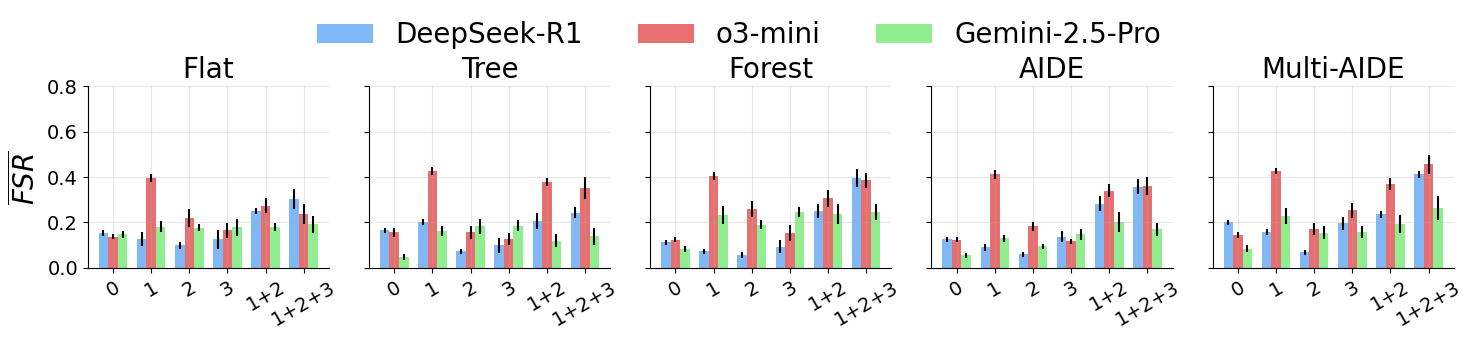

In [17]:
# colors = ['magma', 'plasma']
# colors = ['crimson', 'royalblue']
# colors = ['#7FB8F5', '#E76F6F']
colors = ['#7FB8F5', '#E76F6F', '#90EE90']  # Added a third color (light green)
# colors = [plt.cm.get_cmap('plasma')(level) for level in [0.3, 0.9]]
# x_labels = ['z', 1, 2, 5, 12, 125]
x_labels = [0, 1, 2, 3, '1+2', '1+2+3']
x_values = np.arange(len(x_labels))
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
w = 0.25  # Reduced width to fit 3 bars

# First pass to find average non-zero error
total_err = 0
count = 0
for search_algo in ['flat', 'tree', 'forest', 'ori_aide', 'multi_aide']:
    for model in ['deepseek-r1', 'o3-mini', 'gemini-2.5-pro']:
        for level in ['z', 1, 2, 5, 12, 125]:
            key = f'{search_algo}_{level}_{model}'
            if key in results_by_config:
                err = results_by_config[key]['std']
                if err > 0:
                    total_err += err
                    count += 1
avg_err = total_err / count if count > 0 else 0
min_err_threshold = avg_err / 2

for idx, search_algo in enumerate(['flat', 'tree', 'forest', 'ori_aide', 'multi_aide']):
    for i, model in enumerate(['deepseek-r1', 'o3-mini', 'gemini-2.5-pro']):
        y = []
        err = []
        for level in ['z', 1, 2, 5, 12, 125]:
            key = f'{search_algo}_{level}_{model}'
            if key in results_by_config:
                y.append(results_by_config[key]['means'])
                error = results_by_config[key]['std']
                # Replace zero/nan errors with min_err_threshold
                if error < min_err_threshold or np.isnan(error):
                    error = min_err_threshold
                err.append(error)
            else:
                y.append(0)
                err.append(min_err_threshold)
        axes[idx].bar(x_values - w + i * w, y, width=w, color=colors[i], label=model if idx == 0 else "", yerr=err)

    axes[idx].set_title(['Flat', 'Tree', 'Forest', 'AIDE', 'Multi-AIDE'][idx], fontsize=20)
    axes[idx].set_xticks(x_values)
    axes[idx].set_xticklabels(x_labels, fontsize=14, rotation=30)
    axes[idx].tick_params(axis='y', labelsize=14)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(0, 0.8)
    if idx == 0:
        axes[idx].set_ylabel('$\overline{FSR}$', fontsize=20)

# shared legend above all plots
handles, labels = axes[0].get_legend_handles_labels()
labels = ['Gemini-2.5-Pro' if label == 'gemini-2.5-pro' else
          'o3-mini' if label == 'o3-mini' else
          'DeepSeek-R1' if label == 'deepseek-r1' else label for label in labels]
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=20, frameon=False, bbox_to_anchor=(0.5, 1.18))
fig.tight_layout(rect=[0, 0, 1, 1.05])
# plt.show()
plt.savefig('figures/fsr_across_hint_levels_gemini_o3_deepseek.pdf', dpi=200, bbox_inches='tight')

<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:55: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1422833/2999717431.py:55: SyntaxWarning: invalid escape sequence '\o'
  axes[idx].set_ylabel('$\overline{FSR}$', fontsize=20)


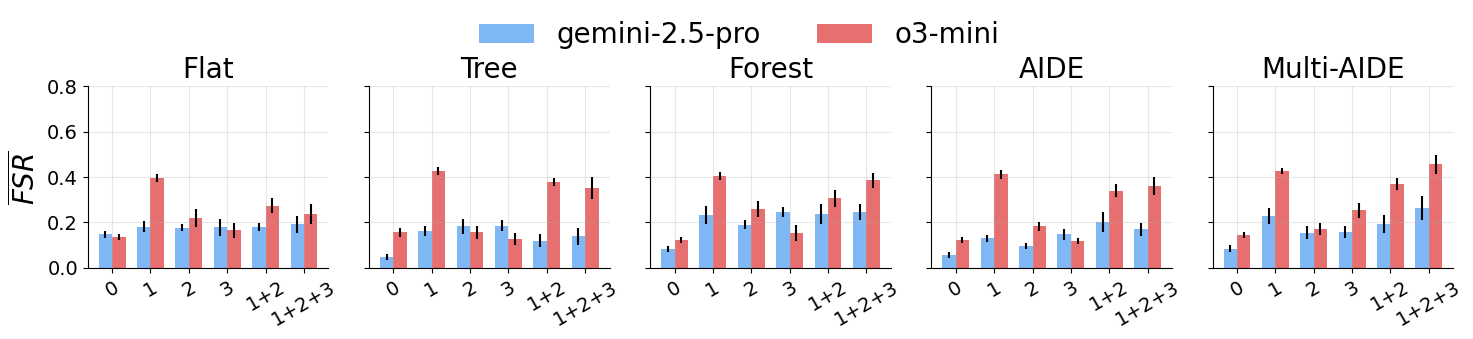

In [18]:
# colors = ['magma', 'plasma']
# colors = ['crimson', 'royalblue']
colors = ['#7FB8F5', '#E76F6F']
# colors = [plt.cm.get_cmap('plasma')(level) for level in [0.3, 0.9]]
# x_labels = ['z', 1, 2, 5, 12, 125]
x_labels = [0, 1, 2, 3, '1+2', '1+2+3']
x_values = np.arange(len(x_labels))
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
w = 0.35
# First pass to find average non-zero error
total_err = 0
count = 0
for search_algo in ['flat', 'tree', 'forest', 'ori_aide', 'multi_aide']:
    # for model in ['deepseek-r1', 'o3-mini']:
    for model in ['gemini-2.5-pro', 'o3-mini']:
        for level in ['z', 1, 2, 5, 12, 125]:
            key = f'{search_algo}_{level}_{model}'
            if key in results_by_config:
                err = results_by_config[key]['std']
                if err > 0:
                    total_err += err
                    count += 1

avg_err = total_err / count if count > 0 else 0
min_err_threshold = avg_err / 2

for idx, search_algo in enumerate(['flat', 'tree', 'forest', 'ori_aide', 'multi_aide']):
    # for i, model in enumerate(['deepseek-r1', 'o3-mini']):
    for i, model in enumerate(['gemini-2.5-pro', 'o3-mini']):
        y = []
        err = []
        for level in ['z', 1, 2, 5, 12, 125]:
            key = f'{search_algo}_{level}_{model}'
            if key in results_by_config:
                y.append(results_by_config[key]['means'])
                error = results_by_config[key]['std']
                # Replace zero/nan errors with min_err_threshold
                if error < min_err_threshold or np.isnan(error):
                    error = min_err_threshold
                err.append(error)
            else:
                y.append(0)
                err.append(min_err_threshold)
        axes[idx].bar(x_values - w/2 + i * w, y, width=w, color=colors[i], label=model if idx == 0 else "", yerr=err)

    axes[idx].set_title(['Flat', 'Tree', 'Forest', 'AIDE', 'Multi-AIDE'][idx], fontsize=20)
    axes[idx].set_xticks(x_values)
    axes[idx].set_xticklabels(x_labels, fontsize=14, rotation=30)
    axes[idx].tick_params(axis='y', labelsize=14)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(0, 0.8)
    if idx == 0:
        axes[idx].set_ylabel('$\overline{FSR}$', fontsize=20)
# shared legend above all plots
handles, labels = axes[0].get_legend_handles_labels()
labels = ['DeepSeek-R1' if label == 'deepseek-r1' else label for label in labels]
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=20, frameon=False, bbox_to_anchor=(0.5, 1.18))

fig.tight_layout(rect=[0, 0, 1, 1.05])
# plt.show()
plt.savefig('figures/fsr_across_hint_levels_gemini_o3.pdf', dpi=200, bbox_inches='tight')

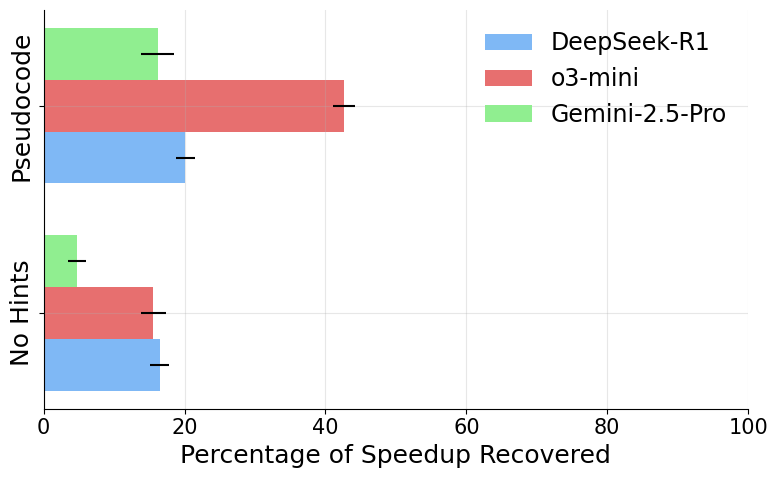

In [19]:
# Create a new figure for horizontal bar plot
plt.figure(figsize=(8, 5))

# Data preparation
# models = ['gemini-2.5-pro', 'o3-mini', 'deepseek-r1']
models = ['deepseek-r1', 'o3-mini', 'gemini-2.5-pro']  # Order for horizontal bar plot
levels = ['z', 1]  # No Hints and pseudocode level 1
x_pos = np.arange(len(levels))
width = 0.25  # Reduced width to fit 3 bars

# Colors matching previous plot
colors = ['#7FB8F5', '#E76F6F', '#90EE90']  # Blue, red, light green

for i, model in enumerate(models):
    y_values = []
    errors = []
    for level in levels:
        key = f'tree_{level}_{model}'  # Using tree search algorithm
        if key in results_by_config:
            y_values.append(results_by_config[key]['means'])
            error = results_by_config[key]['std']
            if error < min_err_threshold or np.isnan(error):
                error = min_err_threshold
            errors.append(error)
        else:
            y_values.append(0)
            errors.append(min_err_threshold)

    # Adjust positioning for 3 bars
    label = 'Gemini-2.5-Pro' if model == 'gemini-2.5-pro' else 'o3-mini' if model == 'o3-mini' else 'DeepSeek-R1'
    plt.barh(x_pos + i*width - width, y_values, height=width,
             xerr=errors, label=label, color=colors[i])

# Customize plot
plt.yticks(x_pos, ['No Hints', 'Pseudocode'], rotation=90, va='center', fontsize=18)
# plt.xlabel('Averaged Fraction of Speed-Up Recovered (%)', fontsize=18)
plt.xlabel('Percentage of Speedup Recovered', fontsize=18)
plt.xlim(0, 1)

# Add percentage x-ticks
xticks = np.arange(0, 1.1, 0.2)
plt.xticks(xticks, [f'{int(x*100)}' for x in xticks], fontsize=15)
plt.legend(frameon=False, fontsize=17)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/fsr_two_levels_gemini_o3_deepseek.pdf', dpi=200, bbox_inches='tight')

In [20]:
from parse_levels import process_metrics_raw_path, list_of_base_paths


In [21]:
r1_codes_dist = pd.read_csv('/checkpoint/maui/zhaobc/scientist/may11_r1_code.csv')
o3_codes_dist = pd.read_csv('/checkpoint/maui/zhaobc/scientist/may11_o3_code.csv')#
gemini_codes_dist = pd.read_csv('/checkpoint/maui/zhaobc/scientist/june1_gemini_code.csv')

In [22]:
o3_codes_dist = pd.concat([r1_codes_dist, o3_codes_dist, gemini_codes_dist],)

In [23]:
o3_codes_dist['run_id'].unique().shape

(4000,)

In [24]:
norm_o3_codes_dist = o3_codes_dist.copy()
norm_o3_codes_dist['norm_cos_start'] = norm_o3_codes_dist['cos_start'] / norm_o3_codes_dist['human_cos']
norm_o3_codes_dist['norm_cos_end'] = norm_o3_codes_dist['cos_end'] / norm_o3_codes_dist['human_cos']
norm_o3_codes_dist['norm_l2_start'] = norm_o3_codes_dist['l2_start'] / norm_o3_codes_dist['human_l2']
norm_o3_codes_dist['norm_l2_end'] = norm_o3_codes_dist['l2_end'] / norm_o3_codes_dist['human_l2']

In [25]:
norm_o3_codes_dist.head()

,method,model,record,levels,run_id,cos_start,cos_end,l2_start,l2_end,human_cos,human_l2,norm_cos_start,norm_cos_end,norm_l2_start,norm_l2_end
0,tree,deepseek-r1,12,z,record_12_20250504_141041_2200393-2200331-1,-1.192093e-07,0.006341,0.0,17.101551,0.006341,17.101551,-0.000019,1.0,0.0,1.0
1,tree,deepseek-r1,8,z,record_8_20250504_161022_2201339-2200955-7,1.192093e-07,0.011043,0.0,22.534748,0.011043,22.534748,0.000011,1.0,0.0,1.0
2,tree,deepseek-r1,19,z,record_19_20250504_181030_2202128-2201681-0,-1.192093e-07,0.039306,0.0,43.281780,0.039306,43.281780,-0.000003,1.0,0.0,1.0
3,tree,deepseek-r1,9,z,record_9_20250504_161022_2201340-2200955-8,1.192093e-07,0.007622,0.0,18.767290,0.007622,18.767290,0.000016,1.0,0.0,1.0
4,tree,deepseek-r1,10,z,record_10_20250504_161022_2200955-2200955-9,0.000000e+00,0.008124,0.0,19.370594,0.008124,19.370594,0.000000,1.0,0.0,1.0


In [26]:
min_train_time_list = []
for idx, row in tqdm(norm_o3_codes_dist.iterrows(), total=len(norm_o3_codes_dist)):
    for base_path in list_of_base_paths:
        run_folder = os.path.join(base_path, row['run_id'])
        if os.path.exists(run_folder):
            break
    metrics = process_metrics_raw_path(run_folder, row['record'])
    min_train_time = metrics['train_time'].min()
    min_train_time_list.append(min_train_time)

100%|██████████| 4000/4000 [01:12<00:00, 54.82it/s] 


In [27]:
norm_o3_codes_dist['min_train_time'] = min_train_time_list
# norm_o3_codes_dist.head()

In [28]:
gap_list = []
model_gap_list = []
for idx, row in tqdm(norm_o3_codes_dist.iterrows(), total=len(norm_o3_codes_dist)):
    record_num = row['record']
    human_time = human_train_time_dict[record_num]
    gap = human_time - human_train_time_dict[record_num+1]
    # model_gap = row['min_train_time'] - human_train_time_dict[record_num+1]
    model_gap = human_time - row['min_train_time']
    gap_list.append(gap)
    model_gap_list.append(model_gap)
norm_o3_codes_dist['gap'] = gap_list
norm_o3_codes_dist['model_gap'] = model_gap_list
# norm_o3_codes_dist.head()


100%|██████████| 4000/4000 [00:00<00:00, 53536.50it/s]


In [29]:
norm_o3_codes_dist['reproduced'] = norm_o3_codes_dist['model_gap'] / norm_o3_codes_dist['gap']
norm_o3_codes_dist.head()


# why so many 1?


,method,model,record,levels,run_id,cos_start,cos_end,l2_start,l2_end,human_cos,human_l2,norm_cos_start,norm_cos_end,norm_l2_start,norm_l2_end,min_train_time,gap,model_gap,reproduced
0,tree,deepseek-r1,12,z,record_12_20250504_141041_2200393-2200331-1,-1.192093e-07,0.006341,0.0,17.101551,0.006341,17.101551,-0.000019,1.0,0.0,1.0,312612.0,28034,5227.0,0.186452
1,tree,deepseek-r1,8,z,record_8_20250504_161022_2201339-2200955-7,1.192093e-07,0.011043,0.0,22.534748,0.011043,22.534748,0.000011,1.0,0.0,1.0,662205.0,156674,0.0,0.000000
2,tree,deepseek-r1,19,z,record_19_20250504_181030_2202128-2201681-0,-1.192093e-07,0.039306,0.0,43.281780,0.039306,43.281780,-0.000003,1.0,0.0,1.0,198981.0,10762,461.0,0.042836
3,tree,deepseek-r1,9,z,record_9_20250504_161022_2201340-2200955-8,1.192093e-07,0.007622,0.0,18.767290,0.007622,18.767290,0.000016,1.0,0.0,1.0,505531.0,28381,0.0,0.000000
4,tree,deepseek-r1,10,z,record_10_20250504_161022_2200955-2200955-9,0.000000e+00,0.008124,0.0,19.370594,0.008124,19.370594,0.000000,1.0,0.0,1.0,477150.0,34165,0.0,0.000000


In [30]:
norm_o3_codes_dist.loc[norm_o3_codes_dist['reproduced'] > 1.5, 'reproduced'] = 0
norm_o3_codes_dist.loc[norm_o3_codes_dist['reproduced'] < 0, 'reproduced'] = 0

In [31]:
norm_o3_codes_dist.loc[norm_o3_codes_dist['norm_l2_end'] > 4, 'norm_l2_end'] = 1.0
norm_o3_codes_dist.loc[norm_o3_codes_dist['norm_l2_end'] < 0.1, 'norm_l2_end'] = 1.0

In [32]:
from matplotlib.legend_handler import HandlerTuple

In [33]:
# # Get unique methods and models
# methods = norm_o3_codes_dist['method'].unique()
# models = norm_o3_codes_dist['model'].unique()

# # Define markers for methods
# markers = {
#     'flat': 'o',      # circle
#     'forest': 's',    # square
#     'multi_aide': '^',  # triangle up
#     'ori_aide': 'v',    # triangle down
#     'tree': 'D'         # diamond
# }

# # Define colormaps for models
# model_cmaps = {'deepseek-r1': plt.cm.Blues, 'o3-mini': plt.cm.Reds}

# # Define level darkness scale (0 to 1)
# level_darkness = {'z': 0.2, '1': 0.3, '2': 0.4, '5': 0.5, '12': 0.7, '125': 0.9}

# fig, ax = plt.subplots(figsize=(15, 8))

# # Plot points
# for method in methods:
#     for model in models:
#         for level in ['z', '1', '2', '5', '12', '125']:
#             mask = (norm_o3_codes_dist['method'] == method) & \
#                    (norm_o3_codes_dist['model'] == model) & \
#                    (norm_o3_codes_dist['levels'] == level)

#             if mask.any():
#                 cmap = model_cmaps[model]
#                 color = cmap(level_darkness[level])
#                 ax.scatter(norm_o3_codes_dist[mask]['reproduced'],
#                          norm_o3_codes_dist[mask]['norm_l2_end'],
#                          marker=markers[method],
#                          c=[color],
#                          alpha=0.7)

# ax.set_xlabel('Reproduced', fontsize=12)
# ax.set_ylabel('L2 End', fontsize=12)
# # ax.set_title('L2 End vs Reproduced by Method, Model and Level', fontsize=14)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.grid(True, alpha=0.3)
# ax.invert_yaxis()

# # Create legend for methods
# method_patches = [plt.Line2D([0], [0], marker=markers[method], color='gray',
#                            label=method, markersize=10, linestyle='None')
#                  for method in methods]

# # Create legend for models and levels
# model_patches = []
# for model in models:
#     cmap = model_cmaps[model]
#     model_patches.append(
#         plt.Line2D([0], [0], marker='s', color=cmap(0.5),
#                    label=model, markersize=10, linestyle='None')
#     )

# level_patches = []
# level_labels = []
# for level in ['z', '1', '2', '5', '12', '125']:
#     label = f'L{level}' if level != 'z' else 'zero knowledge'
#     color1 = model_cmaps['o3-mini'](level_darkness[level])
#     color2 = model_cmaps['deepseek-r1'](level_darkness[level])

#     marker_1 = plt.Line2D([0], [0], marker='o', color=color1, markerfacecolor=color1, markersize=10, linestyle='None')
#     marker_2 = plt.Line2D([0], [0], marker='o', color=color2, markerfacecolor=color2, markersize=10, linestyle='None')
#     level_patches.append((marker_1, marker_2))
#     level_labels.append(label)
#     # level_patches.append(
#     #     plt.Line2D([0], [0], marker='o', color=color,
#     #                 label=label, markersize=10, linestyle='None')
#     # )

# # Place legends at top of figure
# fig.legend(handles=method_patches, title='Methods',
#            bbox_to_anchor=(0.2, 1.10), loc='upper center',
#            ncol=len(method_patches)//2+1, frameon=False, fontsize=12)

# fig.legend(handles=model_patches, title='Models',
#            bbox_to_anchor=(0.5, 1.10), loc='upper center',
#            ncol=len(model_patches), frameon=False, fontsize=12)

# # fig.legend(handles=level_patches, title='Levels',
# #            bbox_to_anchor=(0.8, 1.05), loc='upper center',
# #            ncol=len(level_patches)//2, frameon=False, fontsize=12)
# fig.legend(level_patches, level_labels, title='Levels',
#            handler_map={tuple: HandlerTuple(ndivide=None)},
#            loc='upper center', bbox_to_anchor=(0.8, 1.10),
#            ncol=len(level_patches)//2, frameon=False)

# plt.tight_layout()
# plt.show()

In [34]:
from tqdm import trange
from sklearn.linear_model import LinearRegression

In [35]:
from matplotlib.gridspec import GridSpec


<>:138: SyntaxWarning: invalid escape sequence '\o'
<>:138: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1422833/3652084556.py:138: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\overline{FSR}$', fontsize=16)


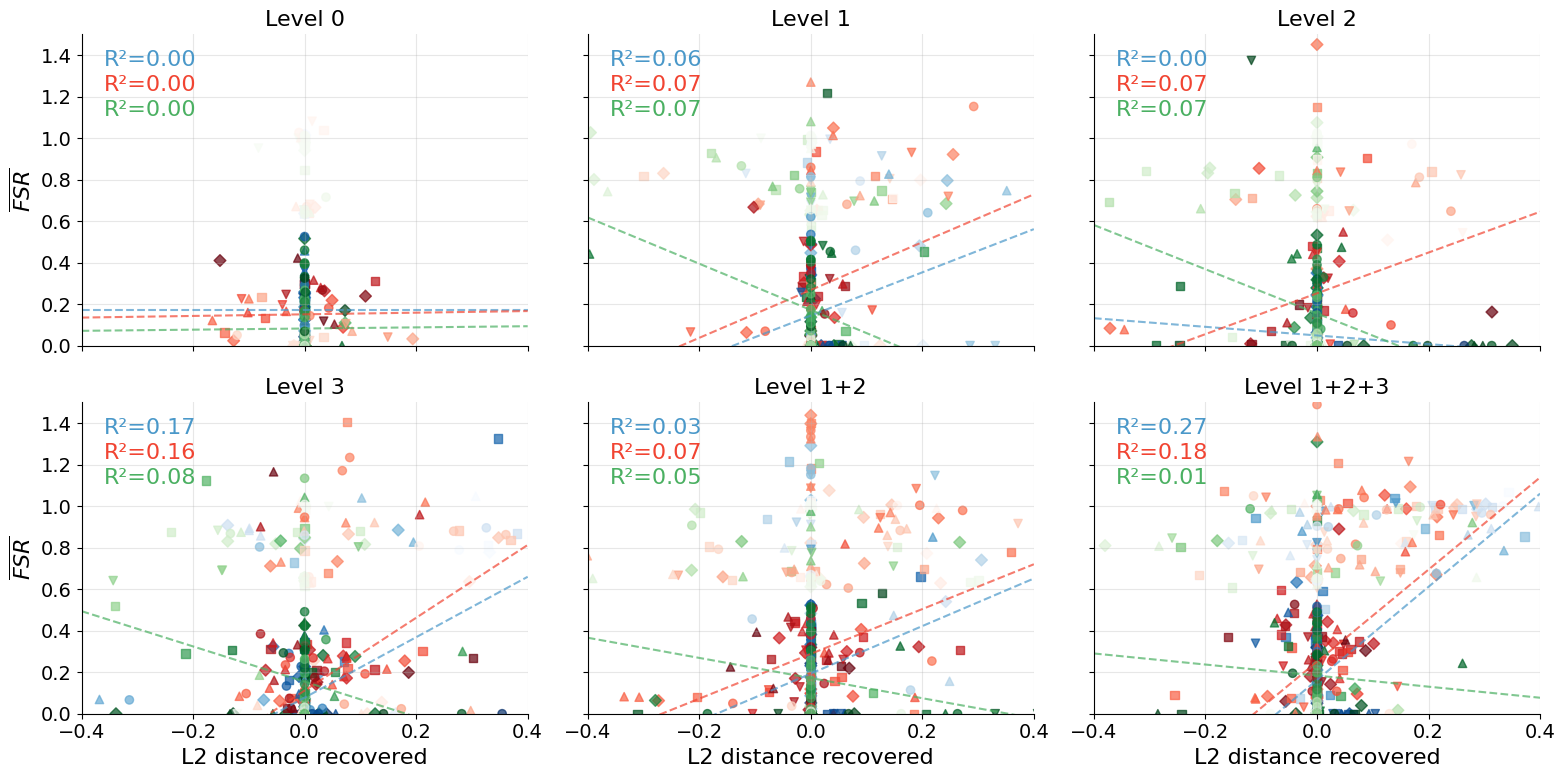

In [36]:
# Get unique methods and models
methods = norm_o3_codes_dist['method'].unique()
models = norm_o3_codes_dist['model'].unique()

# Define markers for methods
markers = {
    'flat': 'o',      # circle
    'forest': 's',    # square
    'multi_aide': '^',  # triangle up
    'ori_aide': 'v',    # triangle down
    'tree': 'D'         # diamond
}

# Define colormaps for models - added third model
model_cmaps = {
    'gemini-2.5-pro': plt.cm.Greens,
    'o3-mini': plt.cm.Reds,
    'deepseek-r1': plt.cm.Blues
}

# fit a line to the points for each model and level pair and compute R^2
model_level_lines = {}
model_level_r2 = {}
model_level_reg = {}

# Get unique levels
levels = norm_o3_codes_dist['levels'].unique()

# For each model-level pair
for model in models:
    model_level_lines[model] = {}
    model_level_r2[model] = {}
    model_level_reg[model] = {}
    for level in levels:
        mask = (norm_o3_codes_dist['model'] == model) & \
               (norm_o3_codes_dist['levels'] == level) #\
                # & (norm_o3_codes_dist['norm_l2_end'] != 1.0)
        x = 1 - norm_o3_codes_dist[mask]['norm_l2_end']  # Changed x to 1-x
        y = norm_o3_codes_dist[mask]['reproduced']
        if len(x) > 0:  # Only fit if we have data points
            # Remove any rows with NaN values
            mask = ~(x.isna() | y.isna())
            x_clean = x[mask]
            y_clean = y[mask]

            if len(x_clean) > 0:  # Check we still have data after removing NaNs
                # Reshape x to 2D array required by sklearn
                X = x_clean.values.reshape(-1, 1)
                # Fit linear regression
                reg = LinearRegression().fit(X, y_clean)
                model_level_reg[model][level] = reg

                # Create prediction function using sklearn predict
                model_level_lines[model][level] = lambda x, model=model, level=level: model_level_reg[model][level].predict(x.reshape(-1, 1))

                # Calculate R^2 score
                r2 = reg.score(X, y_clean)
                model_level_r2[model][level] = r2

# Create figure and gridspec
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, figure=fig)

# Create axes for plots using gridspec
axs = []
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        axs.append(ax)

axs = np.array(axs)

# Create a normalizer for record numbers
norm = plt.Normalize(1, 20)  # Record numbers range from 1 to 20

# Plot each level in a separate subplot
for idx, level in enumerate(['z', '1', '2', '5', '12', '125']):
    ax = axs[idx]
    # Plot points for this level
    for method in methods:
        for model in models:
            mask = (norm_o3_codes_dist['method'] == method) & \
                   (norm_o3_codes_dist['model'] == model) & \
                   (norm_o3_codes_dist['levels'] == level)

            if mask.any():
                cmap = model_cmaps[model]

                # Get data points for this model/method combination
                x = 1 - norm_o3_codes_dist[mask]['norm_l2_end']  # Changed x to 1-x
                y = norm_o3_codes_dist[mask]['reproduced']
                record_nums = norm_o3_codes_dist[mask]['record']

                # Normalize record numbers to [0,1] for color mapping
                norm_records = (record_nums - 1) / 19  # Since records are 1-20
                colors = [cmap(n) for n in norm_records]

                # Plot scatter points
                scatter = ax.scatter(x, y, marker=markers[method], c=colors, alpha=0.7)

    # Plot fitted lines for each model
    r2_text_offset = 0
    for model_idx, model in enumerate(models):
        if level in model_level_lines[model]:
            p = model_level_lines[model][level]
            r2 = model_level_r2[model][level]

            # Generate points for line
            x_line = np.linspace(-0.4, 0.4, 100)  # Adjusted for 1-x transformation
            y_line = p(x_line)

            # Plot line
            color = model_cmaps[model](0.6)
            ax.plot(x_line, y_line, color=color, linestyle='--', alpha=0.7)

            # Add R² text with proper spacing for three models
            ax.text(0.05, 0.95 - (r2_text_offset * 0.08), f'R²={r2:.2f}',
                transform=ax.transAxes, fontsize=16,
                color=color, ha='left', va='top')
            r2_text_offset += 1

    # Customize each subplot
    level_label_mapping = {
        'z': 'Level 0',
        '1': 'Level 1',
        '2': 'Level 2',
        '5': 'Level 3',
        '12': 'Level 1+2',
        '125': 'Level 1+2+3'
    }
    level_label = level_label_mapping[level]
    ax.set_title(level_label, fontsize=16)
    if idx >= 3:  # Only bottom row gets x labels
        ax.set_xlabel('L2 distance recovered', fontsize=16)  # Changed xlabel
    else:
        ax.set_xticklabels([])
    if idx % 3 == 0:  # Only leftmost column gets y labels
        ax.set_ylabel('$\overline{FSR}$', fontsize=16)
    else:
        ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    # ax.tick_params(axis='both', which='major', labelsize=14)

# Set common axis limits
for ax in axs:
    ax.set_ylim(0, 1.5)
    ax.set_xlim(-0.4, 0.4)  # Adjusted for 1-x transformation

# Create legends
method_map_name = {
    'flat': 'Flat',
    'forest': 'Forest',
    'multi_aide': 'Multi-AIDE',
    'ori_aide': 'AIDE',
    'tree': 'Tree'
}
method_patches = [plt.Line2D([0], [0], marker=markers[method], color='gray',
                           label=method_map_name[method], markersize=10, linestyle='None')
                 for method in methods]

# Update model patches for three models
model_labels = {
    'gemini-2.5-pro': 'Gemini-2.5-Pro',
    'o3-mini': 'o3-mini',
    'deepseek-r1': 'DeepSeek-R1'
}
model_patches = [plt.Line2D([0], [0], marker='s', color=model_cmaps[model](0.6),
                          label=model_labels.get(model, model), markersize=10, linestyle='None')
                for model in models]

# Add legends to figure
# fig.legend(handles=method_patches, title='Methods',
#           bbox_to_anchor=(0.36, 1.08), loc='upper center',
#           frameon=False, fontsize=12, ncol=len(method_patches))

# fig.legend(handles=model_patches, title='Models',
#           bbox_to_anchor=(0.75, 1.08), loc='upper center',
#           frameon=False, fontsize=12, ncol=len(model_patches))

plt.tight_layout()
# plt.show()
plt.savefig('figures/FSR_vs_l2_color_code_three_models.pdf', dpi=200, bbox_inches='tight')

In [37]:
cascaded_folder = '/checkpoint/maui/zhaobc/scientist/workspace/test_cascaded_speedup'

In [60]:
# Find all folders in cascaded_folder that match the pattern record_{1/2/3}_*
record_folders = glob.glob(os.path.join(cascaded_folder, 'record_[123]*'))
# print(f"Found {len(record_folders)} folders:")
# for folder in record_folders:
#     print(os.path.basename(folder))

# Gather metrics for each record
from collections import defaultdict
cascaded_metrics = defaultdict(list)
for folder in record_folders:
    folder_name = os.path.basename(folder)
    # Extract record number from folder name
    record_match = re.match(r'record_(\d+)', folder_name)
    if record_match:
        record_num = int(record_match.group(1))
        if record_num in [1, 2, 3]:
            try:
                metrics = gather_metrics(
                    folder,
                    metrics=['val_loss', 'train_time'],
                    workspace_template_path=os.path.join(
                        'workspace_templates',
                        'nanogpt_speedrun',
                        f"record_{record_num}"
                    )
                )
                metrics.loc[metrics['val_loss'] >= 3.29, 'train_time'] = np.nan
                cascaded_metrics[record_num].append(metrics)
                # print(f"Record {record_num}: {len(metrics['step'])} steps")
            except Exception as e:
                print(f"Error processing {folder_name}: {e}")

In [63]:
new_cascaded_metrics = defaultdict(list)
for record_num, metrics_list in cascaded_metrics.items():
    for m in metrics_list:
        # Calculate average train time and loss
        min_train_time = m['train_time'].min()
        new_cascaded_metrics[record_num].append(min_train_time)

In [64]:
new_cascaded_metrics

defaultdict(list,
            {1: [1903098.0,
              2968348.0,
              2195456.0,
              2968348.0,
              2968348.0,
              2214053.0,
              2187090.0,
              2185637.0,
              2968348.0],
             2: [2185637.0, 1852919.0],
             3: [1852919.0]})

In [66]:
human_train_time_dict[1], human_train_time_dict[2], human_train_time_dict[3], human_train_time_dict[4]

(2968348, 2209926, 1386147, 1301740)

In [69]:
# Calculate gap recovered for each record
gap_recovered = defaultdict(list)
for record_num in [1, 2, 3]:
    if record_num in new_cascaded_metrics:
        human_time = human_train_time_dict[record_num]
        human_next_time = human_train_time_dict[record_num + 1]
        gap = human_time - human_next_time

        min_train_time_list = new_cascaded_metrics[record_num]
        model_gaps = []
        for min_train_time in min_train_time_list:
            if not np.isnan(min_train_time):
                model_gap = human_time - min_train_time
                model_gap = max(model_gap, 0)
                model_gaps.append(model_gap)
                gap_recovered[record_num].append(
                    model_gap / gap if gap > 0 else 0
                )


In [70]:
gap_recovered

defaultdict(list,
            {1: [1.4045610491256846,
              0.0,
              1.019079087895657,
              0.0,
              0.0,
              0.9945584384419228,
              1.0301098860528834,
              1.0320257060053637,
              0.0],
             2: [0.029484849698766295, 0.4333771557662917],
             3: [0.0]})

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1422833/962234142.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{FSR}$', fontsize=16)


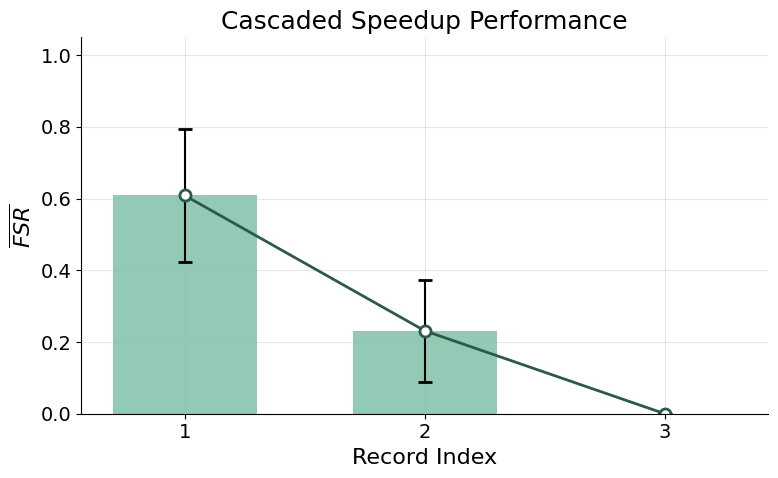

In [78]:
# Compute mean and sem for each record
means = []
sems = []
records = sorted(gap_recovered.keys())

for record in records:
    values = gap_recovered[record]
    means.append(np.mean(values))
    sems.append(np.std(values) / np.sqrt(len(values)))  # Standard error of the mean

# Create bar plot with error bars and line plot
plt.figure(figsize=(8, 5))

# Bar plot
bars = plt.bar(records, means, yerr=sems, width=0.6, color='#64b498',
               capsize=5, error_kw={'capthick': 2}, alpha=0.7)

# Line plot on top
plt.plot(records, means, color='#2d5a47', marker='o', linewidth=2,
         markersize=8, markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Record Index', fontsize=16)
plt.ylabel('$\overline{FSR}$', fontsize=16)
plt.title('Cascaded Speedup Performance', fontsize=18)
plt.xticks(records, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)  # Set y-axis limit to [0, 1.05] for better visibility

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/cascaded_speedup_performance.pdf', dpi=200, bbox_inches='tight')